In [18]:
from qiskit import *
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error
from qiskit.providers.fake_provider import FakeVigo
from qiskit.visualization import plot_distribution
import numpy as np, matplotlib.pyplot as plt

plt.style.use(['science', 'notebook', 'grid', 'dark_background'])

*Maxwell's Demon* (ooh, spooky) is a thought experiment that was first proposed by James Clerk Maxwell in 1867. The idea is that if you had a demon that could open and close a door between two chambers of gas, you could use it to create a temperature difference between the two chambers **without doing any work,** thereby violating the Second Law of Thermodynamics.

A 'microscopic form' of this paradox is *Szilard's Engine,* which is a single-particle version of the demon. The particle can be in one of two states, and the demon can measure the state of the particle and use that information to extract work from the system.

Using quantum circuits, we can demonstrate the components of Szilard's Engine and show that it is possible to extract work from a single particle in a quantum state. We'll use a **maximally mixed** state as the particle qubit. The 'weight' represents
1. $\ket{11}$ as the weight-lifted state (highest energy),
2. $\ket{00}$ as the weight-lowered state (lowest energy), and
3. $\ket{01}$ and $\ket{10}$ as neutral states.

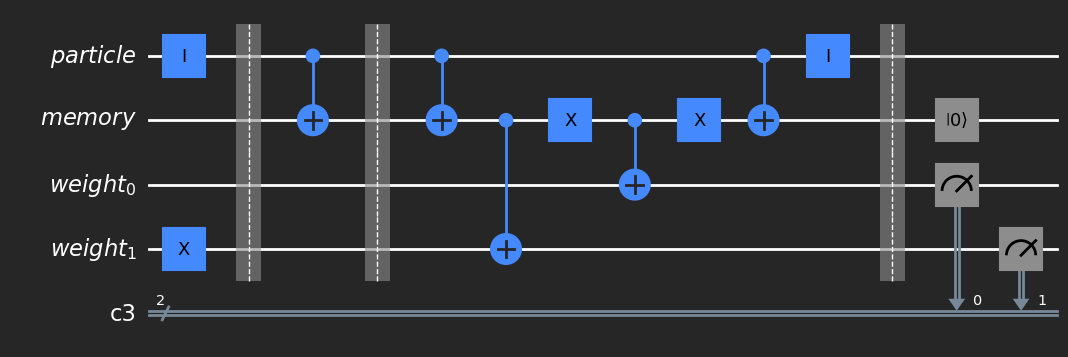

In [19]:
particle = QuantumRegister(1, 'particle')
memory = QuantumRegister(1, 'memory')
weight = QuantumRegister(2, 'weight')
cr = ClassicalRegister(2)

engine = QuantumCircuit(particle, memory, weight, cr)
engine.id(0)
engine.x(3)

engine.barrier()
engine.cx(0, 1)

engine.barrier()
engine.cx(0, 1)
engine.cx(1, 3)
engine.x(1)
engine.cx(1, 2)
engine.x(1)
engine.cx(0, 1)
engine.id(0)

engine.barrier()
engine.reset(1)
engine.measure(2, 0)
engine.measure(3, 1)

engine.draw('mpl', style = 'iqx-dark')

In [20]:
noisemodel = NoiseModel()
error = depolarizing_error(1, 1)

noisemodel.add_quantum_error(error, ['id'], [0])
noisemodel.add_quantum_error(error, ['id'], [1])

print(noisemodel)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['id']
  Qubits with noise: [0, 1]
  Specific qubit errors: [('id', (0,)), ('id', (1,))]


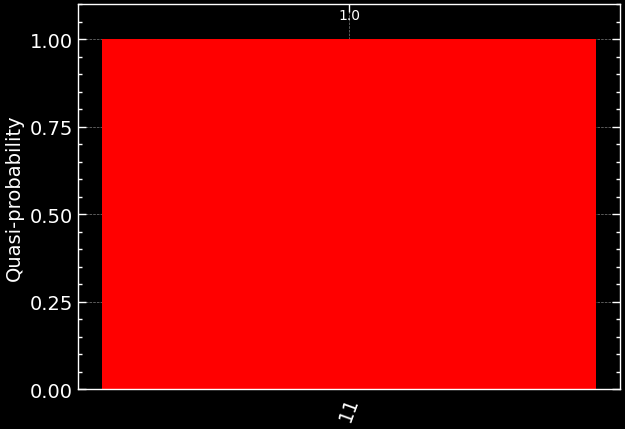

In [21]:
device_backend = FakeVigo()
sim_noise = AerSimulator.from_backend(device_backend, noise_model = noisemodel)
counts = sim_noise.run(engine).result().get_counts()

plot_distribution(counts, color = 'red')

The weights have been successfully lifted. Checking the particle state:

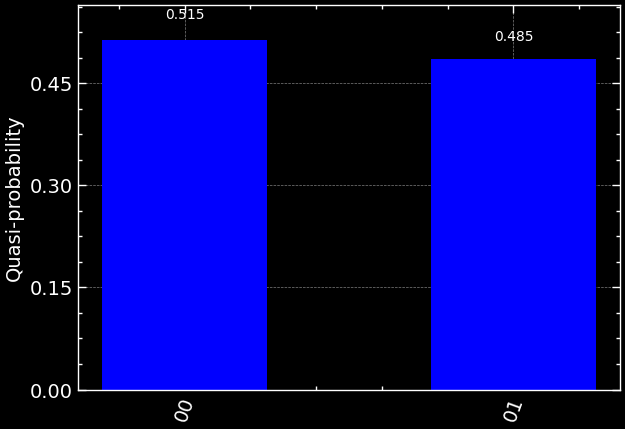

In [22]:
engine = QuantumCircuit(particle, memory, weight, cr)
engine.id(0)
engine.x(3)

engine.barrier()
engine.cx(0, 1)

engine.barrier()
engine.cx(0, 1)
engine.cx(1, 3)
engine.x(1)
engine.cx(1, 2)
engine.x(1)
engine.cx(0, 1)
engine.id(0)

engine.barrier()
engine.reset(1)
engine.measure(0, 0)

counts = sim_noise.run(engine).result().get_counts(0)
plot_distribution(counts, color = 'blue')

And the memory:

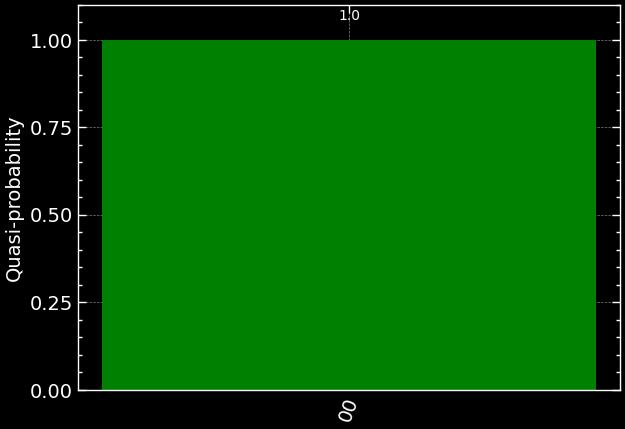

In [23]:
engine = QuantumCircuit(particle, memory, weight, cr)
engine.id(0)
engine.x(3)

engine.barrier()
engine.cx(0, 1)

engine.barrier()
engine.cx(0, 1)
engine.cx(1, 3)
engine.x(1)
engine.cx(1, 2)
engine.x(1)
engine.cx(0, 1)
engine.id(0)

engine.barrier()
engine.reset(1)
engine.measure(1, 0)

counts = sim_noise.run(engine).result().get_counts(0)
plot_distribution(counts, color = 'green')

Understanding why qubit resetting causes entropy loss requires seeing what the reset operation really accomplishes:

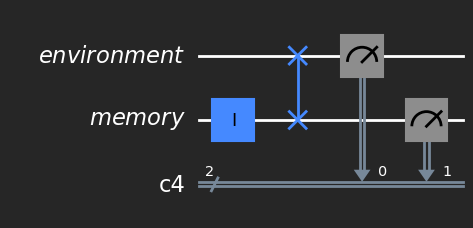

In [24]:
env = QuantumRegister(1, 'environment')
memory = QuantumRegister(1, 'memory')
cr = ClassicalRegister(2)

qc_reset = QuantumCircuit(env, memory, cr)
qc_reset.id(1)
qc_reset.swap(0, 1)
qc_reset.measure([0, 1], [0, 1])

qc_reset.draw('mpl', style = 'iqx-dark')

The price of resetting the qubit is that the demon must erase the memory. This erasure is irreversible and increases the entropy of the demon's memory. The demon can only extract work from the system if the memory is in a state of maximum entropy.

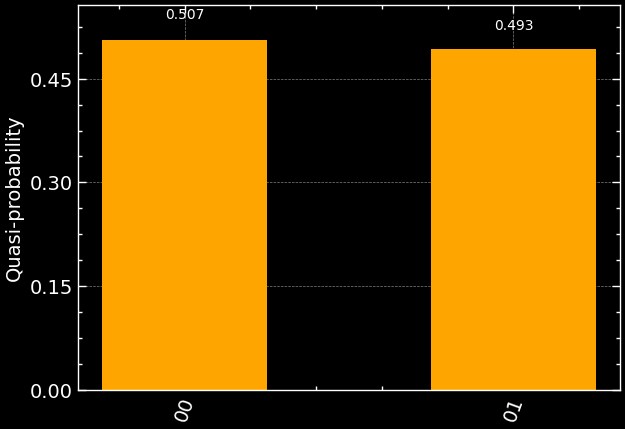

In [25]:
counts = sim_noise.run(qc_reset).result().get_counts()
plot_distribution(counts, color = 'orange')

The use of Landauer's Principle to vanquish Maxwell's Demon is a powerful demonstration of the connection between information theory and thermodynamics, though it remains contested in the scientific community.